<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/AtomicSemanticSegmention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation-based analysis of atomic images

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com



---


This notebook shows i) how to apply a UNet-like neural network for semantic segmentation of atomic images and to perform; ii) how to apply multivariate statistical analysis to the semantically-segmented output.


---



Install AtomAI:

In [ ]:
!pip install atomai

Imports:

In [ ]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

## Semantic segmentation

Download training/test data:

In [ ]:
download_link1 =  'https://www.dropbox.com/s/q961z099trfqioj/ferroics-exp-small-m.npz?dl=0'
download_link2 =  'https://www.dropbox.com/s/w7j12xchjd0at77/lbfo_expdata.npy?dl=0'

!wget -q $download_link1 -O 'training_data.npy'
!wget -q $download_link2 -O 'validation_data.npy'

# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('training_data.npy')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']
# Load validation data (data from different experiment)
expdata = np.load("validation_data.npy")

In [ ]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(1656, 1, 256, 256) (1656, 256, 256)
(414, 1, 256, 256) (414, 256, 256)


The training data was generated from a single labeled experimental STEM image of Sm-doped BFO containing ~20,000 atomic unit cells (see arXiv:2002.04245 and the associated notebook). The "mother image" was ~3000 px x 3000 px. We randomly cropped about 2000 image-masks pairs of 256 x 256 resolution and then applied different image "distortions" (noise, blurring, zoom, etc.) to each cropped image, treating two atomic sublattices as two different classes.

The training/test images and masks represent 4 separate numpy arrays with the dimensions (n_images, n_channels=1, image_height, image_width) for training/test images, and (n_images, image_height, image_width) for the associated masks (aka ground truth). The reason that our images have 4 dimensions, while our labels have only 3 dimensions is because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). Briefly, if you have multiple channels corresponding to different classes in your labeled data, you'll need to map your target classes to tensor indices. Here, we already did this for our training and test data during the preparation stage and so everything is ready for training.

Let's plot some of the training data:

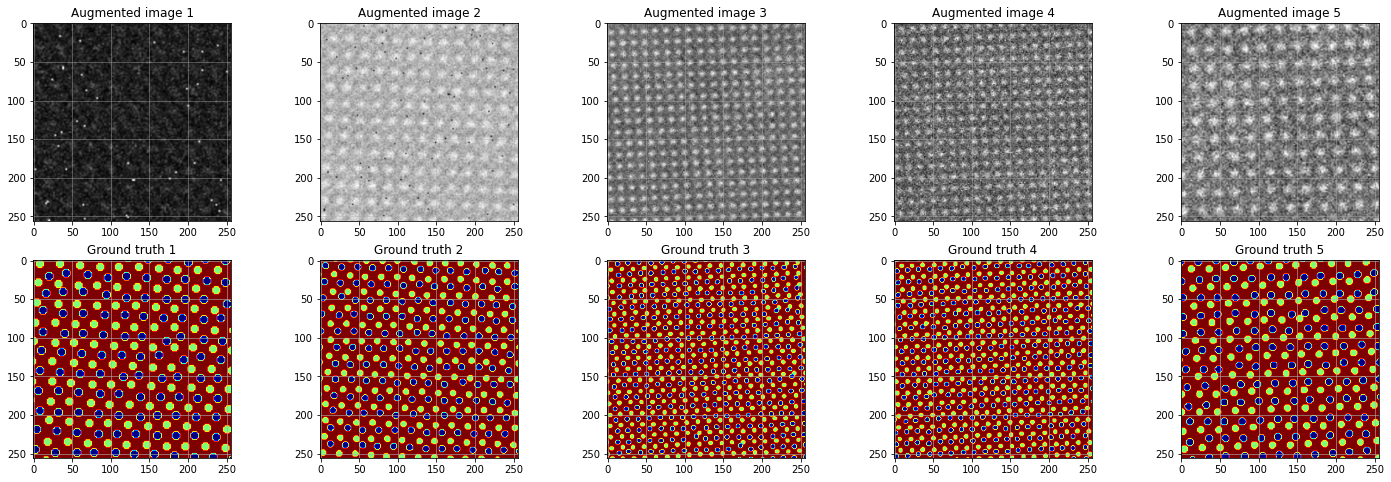

In [ ]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

The neural network will be trained to take the images in the top row (see plot above) as the input and to output clean images of circular-shaped "blobs" on a uniform background in the bottom row, from which one can identify the xy centers of atoms.

We are going to use a [UNet](https://en.wikipedia.org/wiki/U-Net)-like neural network for semantic segmentation. In the semantic segmentation tasks we aim at categorizing every pixel in the image. This is different form a regular image-level classification tasks, where we categorize the image as whole (e.g. this image has a cat/dog, etc.). Here's a nice illustration from this [free book](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf):

<img src="https://drive.google.com/uc?export=view&id=18N4x3P0whH91OcpBOOkDprgWVo-36i34" width=800 px><br><br>

Initialize a nodel for semantic segmentation:

In [ ]:
model = aoi.models.Segmentor(nb_classes=3)

We can also "print" the neural network:

In [ ]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

Epoch 1/300 ... Training loss: 1.2846 ... Test loss: 1.2103 ... Train Accuracy: 0.0901 ... Test Accuracy: 0.0405 ... GPU memory usage: 6522/15109
Epoch 100/300 ... Training loss: 0.4625 ... Test loss: 0.3848 ... Train Accuracy: 0.6634 ... Test Accuracy: 0.6635 ... GPU memory usage: 6522/15109
Epoch 200/300 ... Training loss: 0.2822 ... Test loss: 0.2489 ... Train Accuracy: 0.7241 ... Test Accuracy: 0.7425 ... GPU memory usage: 6522/15109
Epoch 300/300 ... Training loss: 0.2372 ... Test loss: 0.2217 ... Train Accuracy: 0.736 ... Test Accuracy: 0.7428 ... GPU memory usage: 6522/15109
Model (final state) evaluation loss: 0.2391
Model (final state) IoU: 0.7209
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.23
Model (final state) IoU: 0.7289
Plotting training history


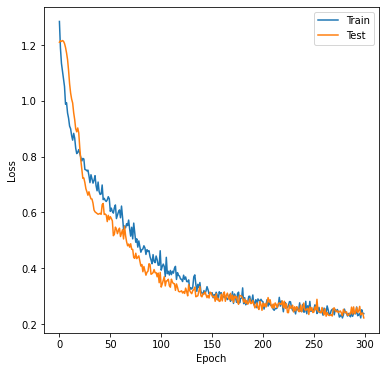

In [ ]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True # training parameters
) 

Now let's make a prediction on the image from a different experiment ( the data is from our paper in *Applied Physics Letters 115, 052902 (2019)* ). Notice that the raw output is a set of semantically segmented blobs (corresponding to different atoms) on a uniform background. We then simply find their centers of the mass, which correspond to the atomic centers (if a network was properly trained).

In [ ]:
nn_output, coordinates = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.2056 seconds


Plot raw prediction:

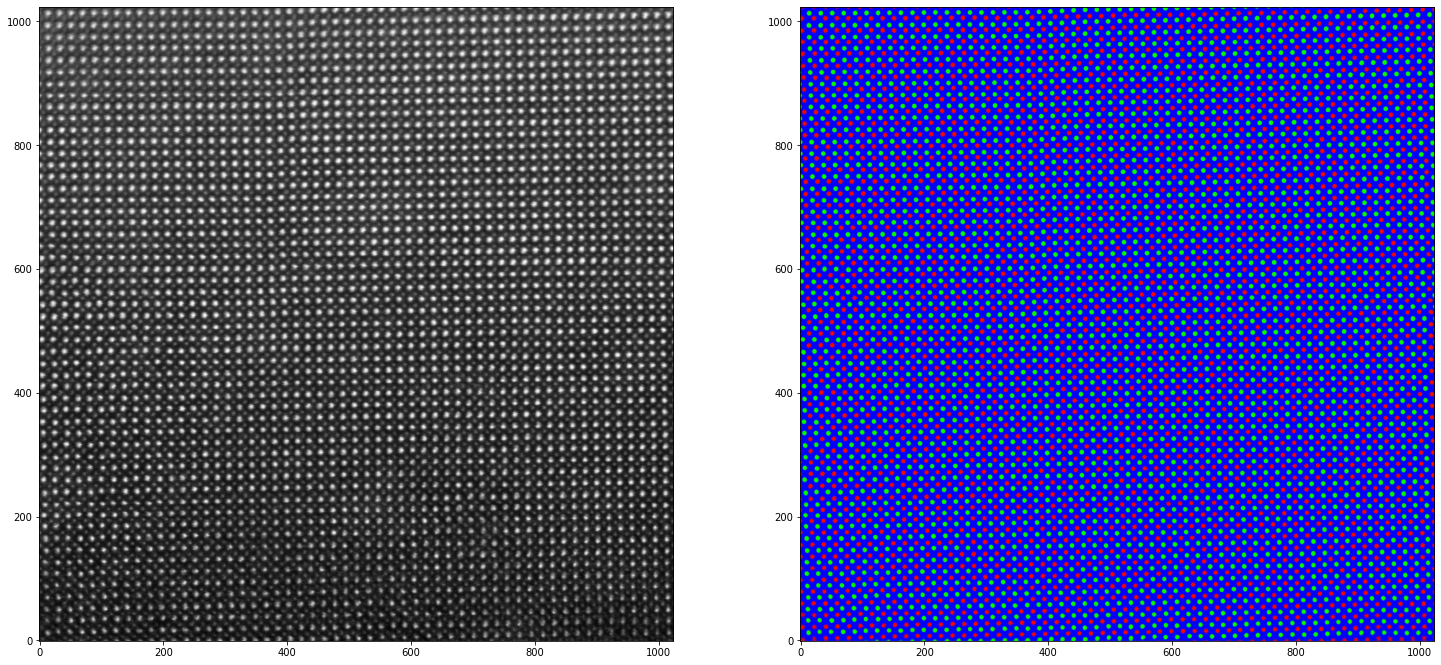

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

Plot atomic coordinates:

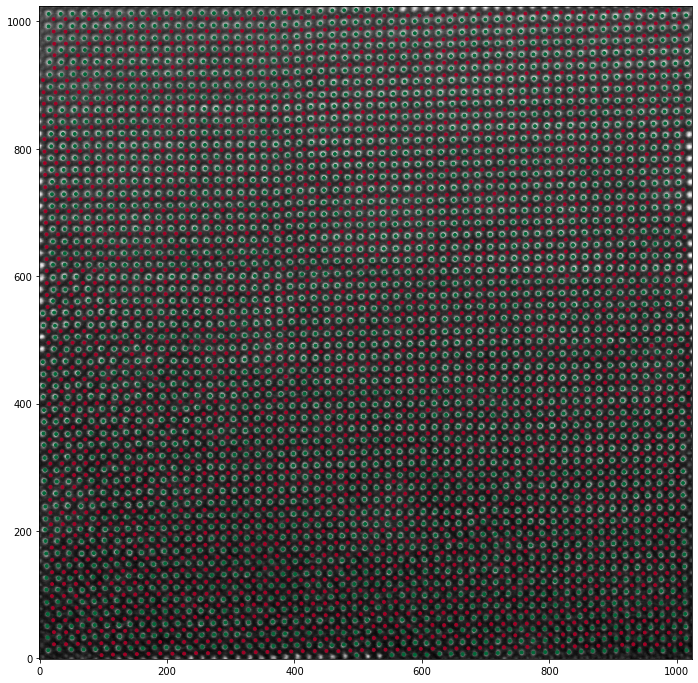

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

Looks like our model performed quite well on the previously unseen data! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky, but we can sometimes compare our results with the results of other methods.

Notice that here we analyzed image with resolution of 1024x1024 even though our network was trained only using 256x256 images. That's the beauty of fully convolutional neural networks (i.e. network without full-connected, dense layers) - it is not sensitive to the size of input image as long as it can be divided by $2^{n}$ where n is a number of max-pooling layers in the network. That said, there is always some optimal pixel-to-angstrom ratio (or, roughly, number of pixels per atom/defect) at which a network will generate the best results. It might be a good idea to determine such a ratio and (if possible) make adjustments to the resolution of experimental images.

Finally, please keep in mind that the model was trained onnly on a single image, so it may not be very robust or generalize well enough. However, the procedure for training on the larger and more diverse training set is exactly the same!

## Multivariate Analysis

Once we have all atomic coordiantes and "cleaned" images we can perform various forms of analysis on local image descriptors. In the remainder of this notebook, we are going to use AtomAI's *stat* module to get a stack of subimages around one of the atom types and perform different types of statistical analysis on them that would reveal the domain structure and the associated "principal" distortions in an unsupervised manner:

Start by get local descriptors, which are subimages centered on one of the sublattices:

In [ ]:
imstack = aoi.stat.imlocal(nn_output, coordinates, window_size=32, coord_class=1)

Compute PCA scree plot to estimate the number of components/sources for the multivariate analysis below:

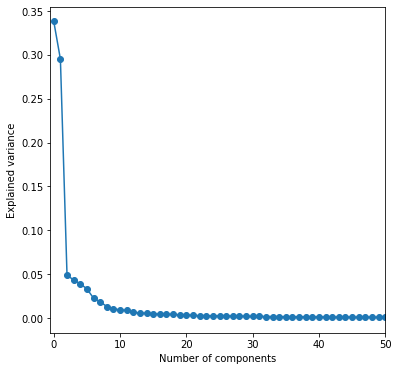

In [ ]:
imstack.pca_scree_plot(plot_results=True);

Do PCA analysis and plot results:

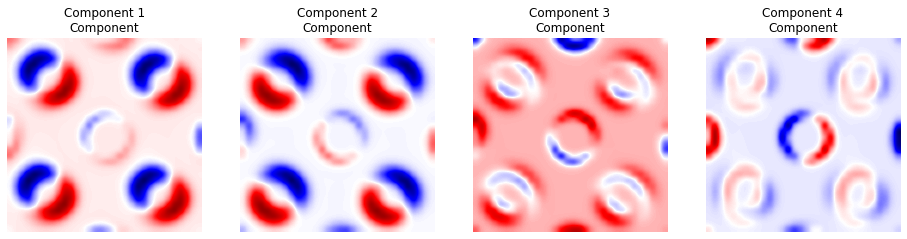

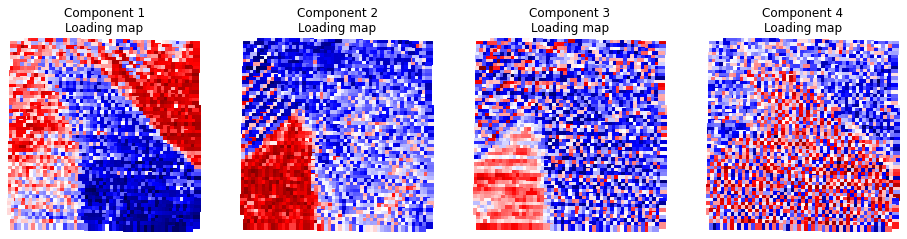

In [ ]:
pca_results = imstack.imblock_pca(4, plot_results=True)

Do ICA analysis and plot results:

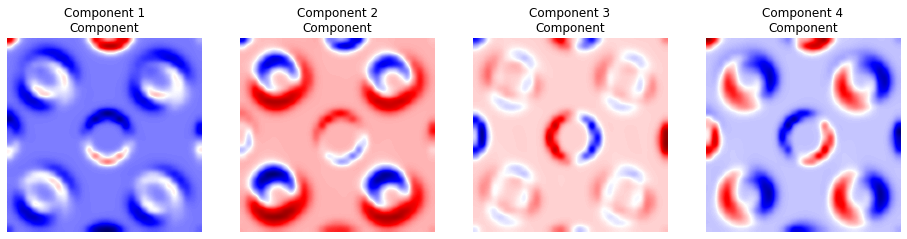

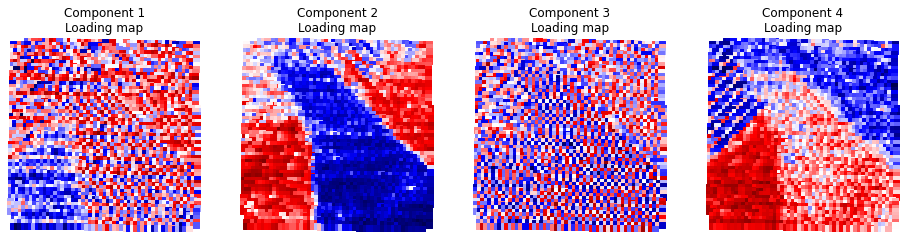

In [ ]:
ica_results = imstack.imblock_ica(4, plot_results=True)

Do NMF analysis and plot results:

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


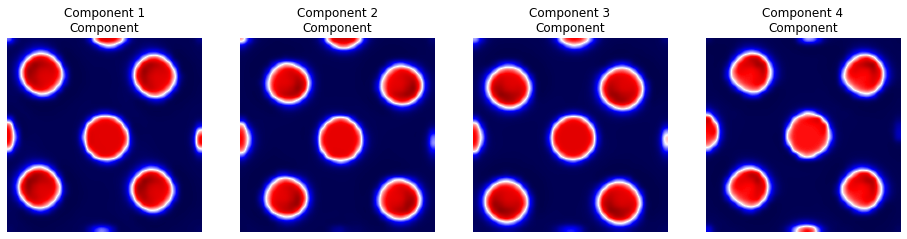

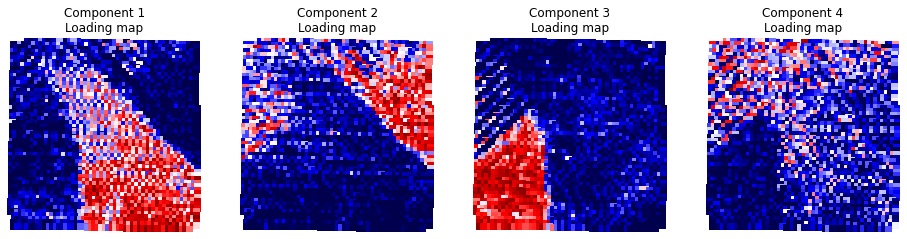

In [ ]:
nmf_results = imstack.imblock_nmf(4, plot_results=True)